In [1]:
import sys
import os
import time
import json
import numpy as np
from scipy.stats import kendalltau
from scipy.spatial import ConvexHull
import pandas as pd
from operator import itemgetter
from itertools import chain
from collections import Counter
from tqdm.notebook import tqdm
from ipywidgets import interact
from plotly.offline import init_notebook_mode, iplot
import cufflinks as cf
init_notebook_mode(connected=True)
cf.go_offline()

from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.preprocessing import normalize

import string
from nltk.corpus import stopwords
from transformers import BertTokenizer

import matplotlib.pyplot as plt

from bert_serving.client import BertClient

import torch
from torch.utils.tensorboard import SummaryWriter

from config import *

In [2]:
def make_pytorch_projector(log_dir, mat, labels=None):
    '''Exports PyTorch projector'''
    writer = SummaryWriter(log_dir)
    writer.add_embedding(mat, metadata=labels)
    writer.close()


def valid_tokens(sentence):
    return list(filter(lambda token: token not in INVALID_TOKENS, sentence))

def tokenize_document(document):
    return list(map(tokenizer.tokenize, document))

def filter_document(document):
    return list(map(valid_tokens, document))

def preprocess(document):
    return filter_document(tokenize_document(document))

def distance(u, B):
    '''Calculates a distance from vector to subspace'''
    return np.linalg.norm(u - (u @ B.T) @ B)


def naive(documents, summaries):
    '''Number of words repeated in the summary'''
    scores = []
    for summary in summaries:
        cnt = Counter(chain(*preprocess(summary)))    
        scores.append(len([cnt[k] for k in cnt if cnt[k] > 1]))
    return scores

def semantic_volume(document_embs, summary_embs):
    # TODO: ask Maxime about implementation
    B = normalize(np.array(document_embs), axis=1)
    scores = []
    for summary in summary_embs:
        R = np.array(summary)
        scores.append(np.average(np.apply_along_axis(distance, 1, R, B)))
    return scores

In [3]:
INVALID_TOKENS = set(stopwords.words('english') + list(string.punctuation))

# Main

## Use-case

1. Take the documents, summaries, and pyramid scores for one topic
2. Embed the documents and summaries (or load embeddings) using bert-as-service (unmodif)
3. Calculate score for summaries
4. Compute correlation with human judgements
5. Export TensorBoard projector

## Get embeddings

In [4]:
# tokenizer = BertTokenizer.from_pretrained('bert-base-uncased')
# bc = BertClient(output_fmt='list') # The tokenizer might be different from the Huggingface's one

In [5]:
# with open(os.path.join(DATA_DIR, DATASETS[0] + '.json')) as fp:
#     tac = json.load(fp)
# tac.keys()

In [6]:
# topic = tac['D0841']

# documents = topic['documents']
# annotations = topic['annotations']

# summaries = list(map(itemgetter('text'), annotations))
# pyr_scores = list(map(itemgetter('pyr_score'), annotations))

In [7]:
# document_embs = []
# for document in tqdm(documents):
#     document_embs.extend(bc.encode(document))

In [8]:
# summary_embs = []
# for summary in tqdm(summaries):
#     summary_embs.append(bc.encode(list(filter(len, summary)))) # Some sents are empty. Why?

## Scores

In [9]:
# naive_scores = naive(documents, summaries)
# kendalltau(pyr_scores, naive_scores)[0]

In [10]:
# semantic_volume_scores = semantic_volume(document_embs, summary_embs)
# kendalltau(pyr_scores, semantic_volume_scores)[0]

## Load embeddings

In [11]:
with open(os.path.join(DATA_DIR, DATASETS[0] + '_encoded.json')) as fp:
    tac = json.load(fp)
tac.keys()

dict_keys(['D0841', 'D0804', 'D0802', 'D0809', 'D0819', 'D0825', 'D0828', 'D0826', 'D0843', 'D0829', 'D0813', 'D0807', 'D0812', 'D0820', 'D0835', 'D0823', 'D0847', 'D0848', 'D0810', 'D0822', 'D0845', 'D0844', 'D0839', 'D0814', 'D0824', 'D0821', 'D0827', 'D0846', 'D0818', 'D0834', 'D0805', 'D0817', 'D0831', 'D0815', 'D0836', 'D0806', 'D0808', 'D0837', 'D0803', 'D0830', 'D0838', 'D0840', 'D0842', 'D0832', 'D0816', 'D0801', 'D0833', 'D0811'])

## Scores

In [27]:
scores = []

for topic_id, topic in tac.items():
    document_embs = list(chain(*topic['documents']))
    annotations = topic['annotations']

    summary_embs = list(map(itemgetter('embedding'), annotations))
    pyr_scores = list(map(itemgetter('pyr_score'), annotations))
    
    try:
        semantic_volume_scores = semantic_volume(document_embs, summary_embs)
        scores.append(kendalltau(pyr_scores, semantic_volume_scores)[0])
    except: # Some summaries are empty
        print(topic_id)
    
np.mean(scores)

D0805


-0.0016107970680001558

In [13]:
topic = tac['D0841']

document_embs = list(chain(*topic['documents']))
annotations = topic['annotations']

summary_embs = list(map(itemgetter('embedding'), annotations))
pyr_scores = list(map(itemgetter('pyr_score'), annotations))

## Plot

In [14]:
def plt_hull(ax, pts, c):
    hull = ConvexHull(pts)
    idx = np.concatenate((hull.vertices, hull.vertices[:1]))
    ax.plot(pts[idx,0],pts[idx,1], f'{c}--', lw=2)
    
def plot(ax, document_pts, summary_pts, add_hull=True):
    ax.scatter(document_pts[:,0],document_pts[:,1],c='b',alpha=0.25 if add_hull else 1)
    ax.scatter(summary_pts[:,0],summary_pts[:,1],c='r',alpha=0.25 if add_hull else 1)
    if add_hull:
        plt_hull(ax, document_pts, 'b')
        plt_hull(ax, summary_pts, 'r')

In [15]:
document_embs_np = np.array(document_embs)
pyr_scores_np = np.array(pyr_scores)
summary_embs_np = np.array(summary_embs)

In [16]:
m = np.argsort(-pyr_scores_np) # Holds sorted indices of the pyramid scores
print(len(m))
m

62


array([61, 59, 42, 12, 60,  3, 49, 58, 56, 23, 22, 30, 26, 10, 14, 41, 11,
       44, 45, 19, 57, 33, 34, 35, 51,  1, 37, 20, 40,  6, 13, 31, 32, 24,
       50, 21, 17, 39, 46, 48,  5, 52, 43, 36, 15, 25,  7, 29, 28, 54, 38,
        4, 55, 18, 27, 16,  2, 47, 53,  0,  9,  8])

In [17]:
n = np.cumsum([len(document_embs)] + list(map(len, summary_embs_np[m]))) # Holds cumulative sum
print(len(n))
n

63


array([195, 205, 211, 216, 221, 228, 232, 236, 240, 243, 246, 249, 251,
       255, 259, 262, 266, 270, 275, 279, 283, 287, 290, 294, 299, 303,
       307, 313, 317, 321, 326, 330, 334, 340, 345, 349, 353, 357, 361,
       366, 370, 373, 377, 385, 386, 391, 395, 401, 406, 407, 411, 415,
       418, 422, 427, 431, 435, 439, 443, 447, 451, 457, 462])

### TensorBoard

In [18]:
t = int(time.time())

data = torch.tensor(document_embs + summary_embs[m[0]])
labels = [0] * len(document_embs) + [1] * len(summary_embs[m[0]])
make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_sumarization_best_{t}'), data, labels)

data = torch.tensor(document_embs + list(chain(*[summary_embs[m[i]] for i in range(len(m))])))
labels = [0] * len(document_embs) + list(chain(*[[i+1] * len(summary_embs[m[i]]) for i in range(len(m))]))
make_pytorch_projector(os.path.join(RUNS_DIR, f'geometry_sumarization_all_{t}'), data, labels)

### Matplotlib + PCA

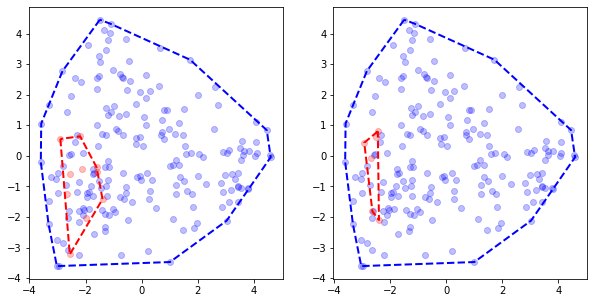

In [19]:
pca = PCA(n_components=2)
document_pts = pca.fit_transform(document_embs)

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
plot(ax1, document_pts, pca.transform(summary_embs[m[0]]), add_hull=True)

ax2 = fig.add_subplot(1,2,2)
plot(ax2, document_pts, pca.transform(summary_embs[m[1]]), add_hull=True)

### Matplotlib + t-SNE

[t-SNE] Computing 91 nearest neighbors...
[t-SNE] Indexed 211 samples in 0.005s...
[t-SNE] Computed neighbors for 211 samples in 0.052s...
[t-SNE] Computed conditional probabilities for sample 211 / 211
[t-SNE] Mean sigma: 2.709821
[t-SNE] KL divergence after 250 iterations with early exaggeration: 65.623611
[t-SNE] KL divergence after 1000 iterations: 0.731465


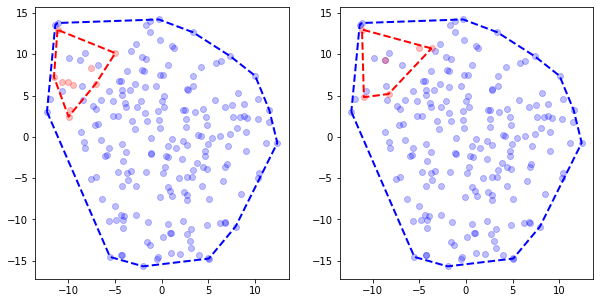

In [20]:
tsne = TSNE(n_iter=1000, perplexity=30, verbose=1)
pts = tsne.fit_transform(document_embs + summary_embs[m[0]] + summary_embs[m[1]])

fig = plt.figure(figsize=(10,5))

ax1 = fig.add_subplot(1,2,1)
plot(ax1, pts[:n[0]], pts[n[0]:n[1]], add_hull=True)

ax2 = fig.add_subplot(1,2,2)
plot(ax2, pts[:n[0]], pts[n[1]:], add_hull=True)

## Interactive plot

### Plotly + PCA

In [21]:
def make_df(pts, label):
    df = pd.DataFrame(pts, columns=['pca-0','pca-1'])
    df['label'] = label
    return df

In [22]:
pca = PCA(n_components=2)
document_pts = pca.fit_transform(document_embs)

df = pd.concat([make_df(document_pts, 'doc')] + \
               [make_df(pca.transform(summary_embs[m[i]]), f'sum-{i+1}') for i in range(len(m))], ignore_index=True)

In [23]:
@interact
def scatter_plot(label=df.label.unique()[1:]):
    df[df.label.isin(('doc',label))].iplot(kind='scatter',
                                           x='pca-0',y='pca-1',
                                           mode='markers',
                                           categories='label',
                                           theme='solar',
                                           colorscale='set1')

interactive(children=(Dropdown(description='label', options=('sum-1', 'sum-2', 'sum-3', 'sum-4', 'sum-5', 'sum…

# Misc

## Extractive Summarization by Maximizing Semantic Volume

Paper: https://www.aclweb.org/anthology/D15-1228.pdf

In [24]:
def mask(N, idx):
    mask = np.ones(N, dtype=bool)
    mask[idx] = False
    return mask

N = n[0]

R = document_embs_np
B = np.ndarray(shape=(0,R.shape[1]))
idx = []

c = R.sum(axis=0) / N

p = np.argmax(np.linalg.norm(R - c, axis=1))
idx.append(p)

q = np.argmax(np.linalg.norm(R - R[p], axis=1))
idx.append(q)

b_0 = R[q] / np.linalg.norm(R[q])
B = np.append(B, b_0.reshape(1,-1), axis=0)

L = 4
for i in range(L):
    r = np.argmax(np.apply_along_axis(distance, 1, R[mask(N, idx)], B))
    if r not in idx:
        idx.append(r)

        b_r = R[r] / np.linalg.norm(R[r])
        B = np.append(B, b_r.reshape(1,-1), axis=0)

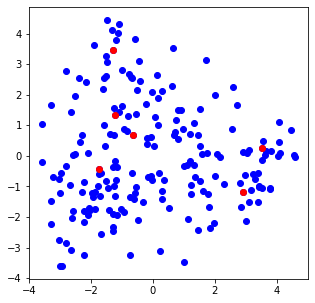

In [25]:
pca = PCA(n_components=2)
document_pts = pca.fit_transform(document_embs)

fig = plt.figure(figsize=(5,5))

ax1 = fig.add_subplot(1,1,1)
plot(ax1, document_pts, pca.transform(document_embs_np[idx]), add_hull=False)